In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium

from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
nltk.download('stopwords')
stop_words = stopwords.words('english')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrdel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrdel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_review = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\NPLRepo Dataset\Hotel_Reviews.csv", index_col=0)

Data Content
The csv file fields. The description of each field is as below:


* Additional_Number_of_Scoring
* Average_Score: Average Score of the hotel, calculated based on the latest comment in the last year.
* Reviewer_Nationality: Nationality of Reviewer: got dummies for 6 nationalities
* Negative_Review: Negative Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then * it should be: 'No Negative'
* Review_Total_Negative_Word_Counts: Total number of words in the negative review.
* Positive_Review: Positive Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Positive'
* Review_Total_Positive_Word_Counts: Total number of words in the positive review.
* Reviewer_Score: Score the reviewer has given to the hotel, based on his/her experience
* Total_Number_of_Reviews_Reviewer_Has_Given: Number of Reviews the reviewers has given in the past.
* Total_Number_of_Reviews: Total number of valid reviews the hotel has.
* Hotel_Address: got dummies already for 6 cities
* Leisure_Trip: stay was for Leisure or not
* Nights_Stayed: the number of nights stayed

In [3]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515738 entries, 0 to 515737
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Additional_Number_of_Scoring                515738 non-null  int64  
 1   Average_Score                               515738 non-null  float64
 2   Negative_Review                             515738 non-null  object 
 3   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 4   Total_Number_of_Reviews                     515738 non-null  int64  
 5   Positive_Review                             515738 non-null  object 
 6   Review_Total_Positive_Word_Counts           515738 non-null  int64  
 7   Total_Number_of_Reviews_Reviewer_Has_Given  515738 non-null  int64  
 8   Reviewer_Score                              515738 non-null  int64  
 9   Days_Since_Review                           515738 non-null  int64  
 10  L

## NULL VALUES & DUPLICATED ROWS

Next, lets check that our data has no null values or duplicated rows:

In [4]:
# Total number of NULL VALUES
print(f'There are {df_review.isna().sum().sum()} NULL VALUES in the dataset.')

There are 0 NULL VALUES in the dataset.


In [5]:
# Duplicated Rows
print(f'There are {df_review.duplicated().sum()} duplicated rows in the dataset.')

There are 539 duplicated rows in the dataset.


There are no null values in the dataset,however, there 539 duplicated rows.

Let's slice them these rows to examine them closer.

In [6]:
# SLice out duplicated rows keeping all instances, sort bynegative review
df_review[df_review.duplicated(keep=False)]

,Additional_Number_of_Scoring,Average_Score,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Days_Since_Review,...,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Leisure_Trip,Nights_Stayed
22083,83,8.3,Nothing,2,549,Good Service,3,5,1,0,...,0,1,0,0,0,0,1,0,0,4
22084,83,8.3,Nothing,2,549,Good Service,3,5,1,0,...,0,1,0,0,0,0,1,0,0,4
23703,728,8.9,none,2,3168,good location and super nice staff room is bi...,13,39,1,159,...,0,1,0,0,1,0,0,0,0,1
23704,728,8.9,none,2,3168,good location and super nice staff room is bi...,13,39,1,159,...,0,1,0,0,1,0,0,0,0,1
61875,300,9.0,No Negative,0,1254,The attention received by Sebastian and his t...,12,4,1,7,...,0,1,0,0,1,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471973,311,8.3,Nothing,2,3720,Location and staff,4,20,0,718,...,0,0,0,0,0,1,0,0,1,2
489214,904,8.1,The location is too far from city center 1 km...,29,16670,Excellent breakfast variaty of goods wifi goo...,16,11,0,577,...,0,1,0,0,0,1,0,0,1,1
489215,904,8.1,The location is too far from city center 1 km...,29,16670,Excellent breakfast variaty of goods wifi goo...,16,11,0,577,...,0,1,0,0,0,1,0,0,1,1
492717,162,8.6,No Negative,0,2286,The hotel is a beautiful gallery boutique hot...,108,18,1,692,...,1,0,0,0,0,1,0,0,1,1


**Observations:** There should be no reason to have duplicates in this dataset. One possible reason that we do have them could be that a reviewer ran into technical issued when submitting and decided to submit their review again. Another possible issue could have been during the data creation stage.Therefore, these duplicates are actually duplicates which should be dropped.

We can now drop these duplicated rows and just keep the first occurence:

In [7]:
# drop duplicated rows
df_review.drop_duplicates(keep = 'first',inplace= True)

In [8]:
# sanity check of duplicated rows
print(f'There are {df_review.duplicated().sum()} duplicate raws in the dataset.')

There are 0 duplicate raws in the dataset.


## Distribution of Columns

Since all of our columns are numerical, let's take look at their distribution.

We have a good number of binery columns, so let's figure out which ones are those and we will jnot be visulizing these distributions.

In [9]:
# print number of unique values in each column
for i in df_review.columns:
    print(f'There are {df_review[i].nunique()} unique values in {i} column')

There are 480 unique values in Additional_Number_of_Scoring column
There are 34 unique values in Average_Score column
There are 330011 unique values in Negative_Review column
There are 402 unique values in Review_Total_Negative_Word_Counts column
There are 1142 unique values in Total_Number_of_Reviews column
There are 412601 unique values in Positive_Review column
There are 365 unique values in Review_Total_Positive_Word_Counts column
There are 198 unique values in Total_Number_of_Reviews_Reviewer_Has_Given column
There are 2 unique values in Reviewer_Score column
There are 731 unique values in Days_Since_Review column
There are 1489 unique values in Latitude column
There are 1489 unique values in Longitude column
There are 31 unique values in Day column
There are 12 unique values in Month column
There are 3 unique values in Year column
There are 2 unique values in Reviewer_Nationality_Australia column
There are 2 unique values in Reviewer_Nationality_Ireland column
There are 2 unique 

Looking at the unique values in each column, we can pick out which ones are binery which are not.

let's create a new data frame, dropping all of our binery columns as well as positive and negetive reviews as it does not make sense to plot distribution of columns with non numerical values. 

In [10]:
# instantiate a list to hold columns with 2 values and prechosen columns meant to be dropped.
dropping_columns = ['Positive_Review','Negative_Review']
# for all columns
for i in df_review.columns:
    # if the number of unique values in columns are 2
    if df_review[i].nunique()<=2:
        #append the column to the previously created list
        dropping_columns.append(i)

Sanity check to ensure the columns got appended correctly.

In [11]:
dropping_columns

['Positive_Review',
 'Negative_Review',
 'Reviewer_Score',
 'Reviewer_Nationality_Australia',
 'Reviewer_Nationality_Ireland',
 'Reviewer_Nationality_UAE',
 'Reviewer_Nationality_UK',
 'Reviewer_Nationality_USA',
 'Reviewer_Nationality_Other',
 'Hotel_Address_Amsterdam',
 'Hotel_Address_Barcelona',
 'Hotel_Address_London',
 'Hotel_Address_Milan',
 'Hotel_Address_Paris',
 'Hotel_Address_Vienna',
 'Leisure_Trip']

These look correct, now we can drop them and plot the distribution of remaing columns.

In [12]:
# create dataframe of non_binery columns
dist_df = df_review.drop(columns=dropping_columns)

After a quick sanity check, we have 13 numerical features that are not binary.

let's plot out histagrams of each column's distribution:

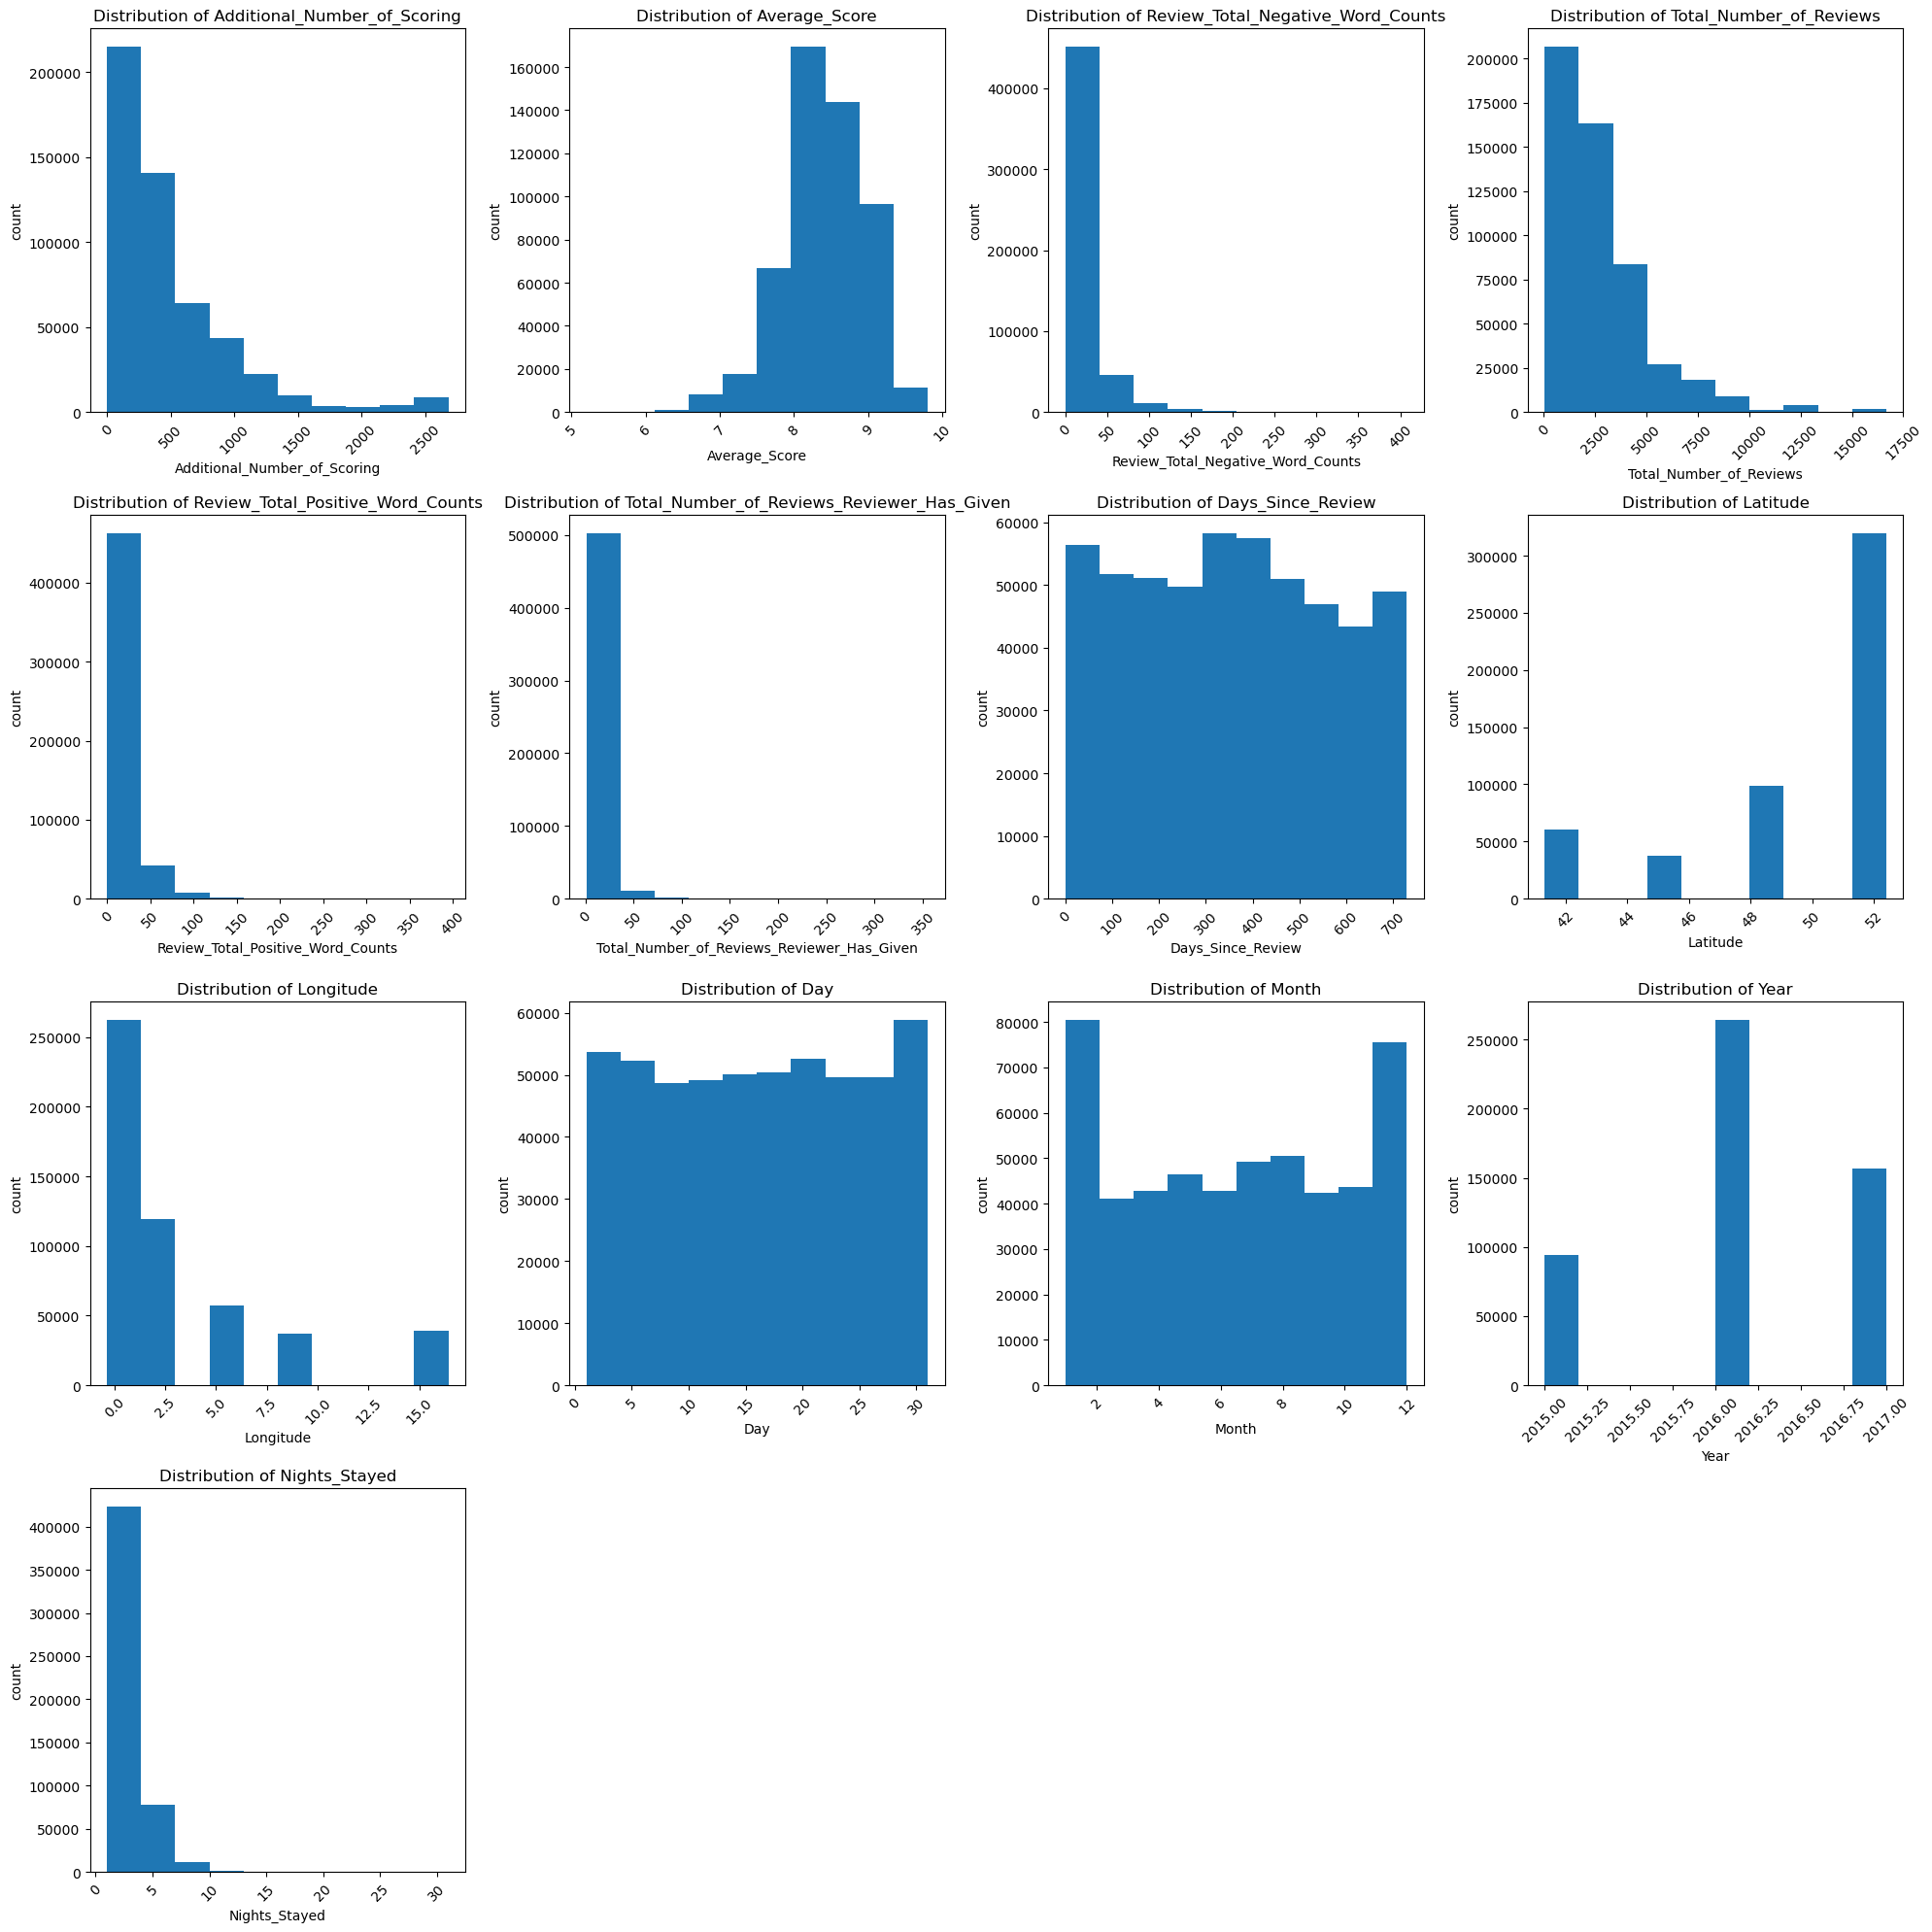

In [13]:
# Distribution of all columnsin 4*4 grid
plt.figure(figsize=(20,20))
for i,col in enumerate(dist_df.columns):
    plt.subplot(4,4,i+1)
    plt.hist(dist_df[col])
    plt.title(f'Distribution of {col}')
    plt.ylabel('count')
    plt.xlabel(col)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

To fully understand the distributions of the columns, we can pair these visuals with a statistical summary:

In [14]:
# statstical summary
dist_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Additional_Number_of_Scoring,515199.0,498.417604,500.673193,1.000000,169.000000,342.000000,660.000000,2682.000000
Average_Score,515199.0,8.397776,0.547947,5.200000,8.100000,8.400000,8.800000,9.800000
Review_Total_Negative_Word_Counts,515199.0,18.540711,29.693602,0.000000,2.000000,9.000000,23.000000,408.000000
Total_Number_of_Reviews,515199.0,2744.691424,2318.112418,43.000000,1161.000000,2134.000000,3633.000000,16670.000000
Review_Total_Positive_Word_Counts,515199.0,17.778489,21.804665,0.000000,5.000000,11.000000,22.000000,395.000000
Total_Number_of_Reviews_Reviewer_Has_Given,515199.0,7.164750,11.039315,1.000000,1.000000,3.000000,8.000000,355.000000
Days_Since_Review,515199.0,354.402120,208.909135,0.000000,175.000000,353.000000,527.000000,730.000000
Latitude,515199.0,49.433012,3.461933,41.328376,48.214066,51.499981,51.516288,52.400181
Longitude,515199.0,2.893915,4.669672,-0.369758,-0.143372,0.019886,4.841163,16.429233
Day,515199.0,15.680589,8.864227,1.000000,8.000000,16.000000,23.000000,31.000000


**Observation** : Looking at all our columns, we can see that the majority are heavily skewed to the right. the only column that has a somewhat normal distribution is `Average_score`.
* 75% of reviewers have less than 8 total reviews given.
* 75% of review words counts are under 23.
* Most reviewers stay at the hotel for less than 3 days.
* Our data spans over 3 years, from 2015 to 2017.

# Distribution of Target Column
The last part of our EDA is going to be looking at our target column, which is `Reviewer_Score`.

The goal is to figure our data is split to that we can better understand how our model is going to perform.

Let's take a look at the relative percentages of good and bad reviews and then plot our this split. 

In [15]:
# Value count
df_review['Reviewer_Score'].value_counts(normalize=True)

Reviewer_Score
1    0.5701
0    0.4299
Name: proportion, dtype: float64

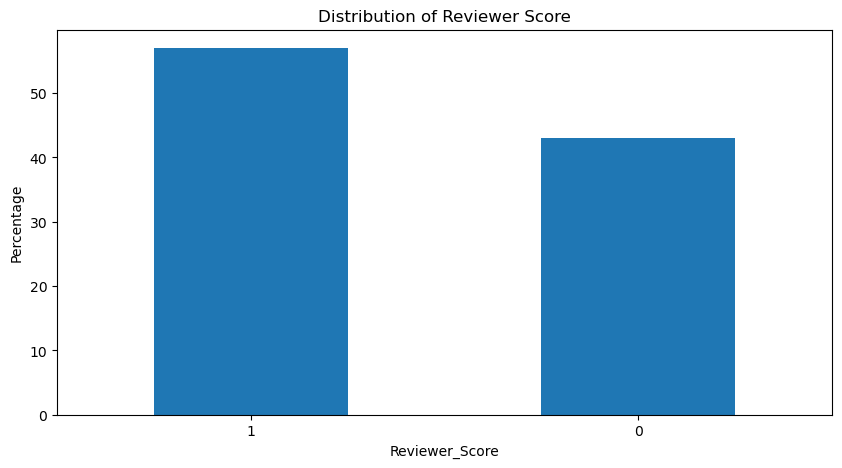

In [16]:
# Bar chart of Reviewer_Score
plt.figure(figsize=(10,5))
(df_review['Reviewer_Score'].value_counts(normalize=True)*100).plot(kind='bar')
plt.title('Distribution of Reviewer Score')
plt.ylabel('Percentage')
plt.xlabel('Reviewer_Score')
plt.xticks(rotation=0)
plt.show()

**Observations** : Our target column is slightly imbalanced, with good reviews taking up 57% of the data, and bad reviews taking up 43%. When it comes to modelling, this can skew our results as the model will be biased towards the majority class. This split also tells us that we blindly guess all reviews to be good, we would be correct 57% of the time.

57% is going to be our base accuracy when modeling.

# Preprocessing

Now that we have explored our data more in depth,we can move onto preprocessing our text features,`Positive_Review` and `Negative_Review`for modeling.

## Train Test Split

first we assign our X and y. Since our target column is `Reviewer_Score`. Wewe will drop it from X and we will make it our y.

In [17]:
# Split X and y
X = df_review.drop(columns='Reviewer_Score')
y = df_review['Reviewer_Score']

After assigning our X and y, we can perform a train/test split with SKLearn. WE will be using a test size of 25% as well as stratifying due to imbalance of our data. 

We split our data in train and test sets so that we can test our model on unseen data.Testing on unseen data is the last step in modeling process to validate that our model can still perform well when it comes across data that is doesn't know.

In [18]:
# split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.25, stratify = y, random_state = 42)

In [19]:
# check shape of train and test sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(386399, 28) (128800, 28) (386399,) (128800,)


# Count Vectorization

After splitting our data into train and test sets, we can move on to vectorizing our review columns. Using a Count Vectorizer, we will be able to turn our text columns into a number of binery columns. The vectorizer will split the reviews by word and then create a binery column that identifies if the word is in the review or not.


We will be using the function `my_tokenizer` that will clean the reviews before being put into the vectorizer. The function will go through a 3 steps process:

1. Remove all punctuation
2. Split the string and remove stopwords(common englishwords found in almost every sentence that will not be useful in predictions)
3. Stem each word in the string( extracts a root from similar words. For example, fish, fishing, fisher, will be stemmed into fish.)

**Reference:** Taken from NLP Solutions Notebook

In [20]:
# tokenizer function
stemmer = PorterStemmer()
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    '''
    Takes a sentence:
    - Removes the punctuation
    - Separates and Removes Stop Words
    - stems a remaing tokens
    
    Returns list of stemmed tokens
    '''
    # Remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark, '').lower()
        
    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word != ''):
            #stems_words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)
            
    return listofstemmed_words

Now that we have cleaning function lay out, wer can move on to vectorizing `Positive_Review` and `Negative_Review`.

In this step we will be instantiating the vectorizer, fitting it to our traing data, and then transforming both our training and test data sets.

We have set `min_df` to 10. This will only keep words that are seen in more than 10 documents.

We have also set `max_features` to 500. This will cap the number of words we extract to 500 for positive and 500 for negative reviews.

In [21]:
# Instantiate, fit, transform positive vectorizer
pos_vec = CountVectorizer(tokenizer = my_tokenizer, min_df= 10, max_features= 500)
pos_vec = pos_vec.fit(X_train['Positive_Review'])
pos_train = pos_vec.transform(X_train['Positive_Review'])
pos_test = pos_vec.transform(X_test['Positive_Review'])

# Instantiate, fit, transform negative vectorizer
neg_vec = CountVectorizer(tokenizer = my_tokenizer, min_df= 10, max_features= 500)
neg_vec = neg_vec.fit(X_train['Negative_Review'])
neg_train = neg_vec.transform(X_train['Negative_Review'])
neg_test = neg_vec.transform(X_test['Negative_Review'])

Now that our columns have been vectorized, we can check the size of each to make sure that is went according to plan

In [22]:
# size of all sparse metrix
print(pos_train.shape,pos_test.shape,neg_train.shape,neg_test.shape)

(386399, 500) (128800, 500) (386399, 500) (128800, 500)


all of our sparse matrixes are correct with 500 words.

Next, we are going to convert these matrixes to array and put them in a data frame. This will be done separately for positive and negative words:

In [23]:
# Bag of words pos train and test, add prefix to each column name
pos_train_df = pd.DataFrame(pos_train.toarray(), columns = [f'pos_{col}' for col in pos_vec.get_feature_names_out()])
pos_test_df = pd.DataFrame(pos_test.toarray(), columns = [f'pos_{col}' for col in pos_vec.get_feature_names_out()])

neg_train_df = pd.DataFrame(neg_train.toarray(), columns = [f'neg_{col}' for col in neg_vec.get_feature_names_out()])
neg_test_df = pd.DataFrame(neg_test.toarray(), columns = [f'neg_{col}' for col in neg_vec.get_feature_names_out()])


Now we have 2 data frame containing out negative and positive words. we can concatenate both of our positive and negative training sets into one large traing set and do the same for test data sets.

In [24]:
# concat pos and neg train
pos_neg_train = pd.concat([pos_train_df,neg_train_df], axis=1)

# concat pos and neg test
pos_neg_test = pd.concat([pos_test_df,neg_test_df], axis=1)

Let's take alook at our train and test sets and make sure that only have a max of 1000 columns in them:

In [25]:
# train head
pos_neg_train.head()

,pos_1,pos_10,pos_15,pos_2,pos_20,pos_3,pos_30,pos_4,pos_5,pos_abl,...,neg_wi,neg_wifi,neg_window,neg_without,neg_work,neg_worst,neg_worth,neg_would,neg_wrong,neg_year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# test head
pos_neg_test.head()

,pos_1,pos_10,pos_15,pos_2,pos_20,pos_3,pos_30,pos_4,pos_5,pos_abl,...,neg_wi,neg_wifi,neg_window,neg_without,neg_work,neg_worst,neg_worth,neg_would,neg_wrong,neg_year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Both our train and test sets are the correct size so we can now concatenate with our orginal train and test data so that we include the other features associated with our data.

We should have all our positive and negative words along with the orginal columns in the data.

In [27]:
# concat pos_neg_train and X_train
X_train = pd.concat([X_train.reset_index(drop= True), pos_neg_train.reset_index(drop=True)], axis = 1)

# concat pos_neg_train and X_test
X_test = pd.concat([X_test.reset_index(drop= True), pos_neg_test.reset_index(drop=True)], axis = 1)

# drop positive and negative reviews columns
X_train.drop(columns= ['Positive_Review','Negative_Review'], inplace=True)
X_test.drop(columns= ['Positive_Review','Negative_Review'], inplace=True)

Let's do a quick sanity check on both our train and test sets to make sure that the concatenation was successful.

We should have all of our positive and negative words along with the orginal columns in data.

In [28]:
# sanity check on train
X_train.head()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Days_Since_Review,Latitude,Longitude,Day,...,neg_wi,neg_wifi,neg_window,neg_without,neg_work,neg_worst,neg_worth,neg_would,neg_wrong,neg_year
0,169,8.1,29,1787,32,23,334,48.211084,16.383841,3,...,0,0,0,0,0,0,0,0,0,0
1,854,7.8,5,3867,8,6,400,51.494231,-0.185114,29,...,0,0,0,0,0,0,0,0,0,0
2,102,9.3,0,361,8,2,582,51.504439,-0.149911,30,...,0,0,0,0,0,0,0,0,0,0
3,244,8.5,0,1831,9,16,555,51.491888,-0.194971,26,...,0,0,0,0,0,0,0,0,0,0
4,908,8.5,0,3980,3,5,96,51.514400,-0.156551,29,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# sanity check on test
X_test.head()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Days_Since_Review,Latitude,Longitude,Day,...,neg_wi,neg_wifi,neg_window,neg_without,neg_work,neg_worst,neg_worth,neg_would,neg_wrong,neg_year
0,690,8.6,18,2890,14,7,201,51.503940,-0.224423,14,...,0,0,1,0,0,0,0,0,0,0
1,199,8.6,45,1424,22,6,417,41.386018,2.194730,12,...,0,0,0,0,0,0,0,1,0,0
2,765,8.4,18,4686,18,1,33,52.372707,4.894366,1,...,0,0,0,0,0,0,0,0,0,0
3,237,8.4,93,2179,0,1,47,52.310118,4.947292,17,...,0,0,0,0,0,0,1,2,0,0
4,472,8.0,4,1378,10,6,256,51.470360,-0.177987,20,...,0,0,0,0,0,0,0,0,0,0


Both of our sets have 1026 columns.

All of our data is now numerical and we are ready to modeling.

# Modeling

The first model that we are going to start with is Logistic Regression. In this stage, we will just be using the base model meaning that we will not be tweaking any of model's parameters.

We will then get the train and the test accuracy score and figure out thge top 20 positive and top 20 negative words that are most predictive of a good or bad review. 

## Logistic Regression
We are going to import Logistic Regression from SKlearn, fit it to training data, then output both the train and test accuracies. When looking at accuracies, we want to see minimal difference between the two. If our training accuracy is alot larger than our test accuracy, that means that the model is overfitting.

In [30]:
# instantiate and fitt logistic reggresion
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

# train and test accuracy
print(f'Train Score: {logreg.score(X_train,y_train)}')
print(f'Test Score: {logreg.score(X_test,y_test)}')

Train Score: 0.7106333090924148
Test Score: 0.7093090062111801


Looking at the results, we have a test accuracy of 70.9%. Given that our base accuracy is 57%, the model is not performing too bad. However, there is a lot of room for improvment.

It is important to note that we are seeing no overfitting as both our train and test accuracies are 0.13% apart from each other.

Here is our model summary:

| **Model**     | **PCA?**| **Parameters** | **Train Accuracy(%)** | **Test Accuracy(%)** | **Notes** |
| ------------- |:-------------:| -----:|:-------------------------:|:--------------------:|:-------:|
| Logistic Regression| No | N/A |71.1|70.9|No overfitting|

Next, we are going to extract the regression coefficients for each of the features and put then into a dataframe:

In [31]:
# put coeficients in a dataframe
coef_df = pd.DataFrame({'feature':X_train.columns, 'coef':logreg.coef_[0]})
coef_df

,feature,coef
0,Additional_Number_of_Scoring,0.000241
1,Average_Score,0.036593
2,Review_Total_Negative_Word_Counts,-0.041141
3,Total_Number_of_Reviews,-0.000086
4,Review_Total_Positive_Word_Counts,0.037178
...,...,...
1021,neg_worst,-0.000268
1022,neg_worth,-0.000199
1023,neg_would,0.003481
1024,neg_wrong,0.000018


Looking at our coeficients dataframe, we can see that we have out pos/neg words as well as our orginal columns.

To find the top 20 pos/neg words, we are going to extract only the words from our coeficients.

We will be creating two new data frame, one for positive words and one for negative words:

In [32]:
# separate pos and neg coeficients

pos_coef_df = coef_df[coef_df['feature'].str.contains('pos_')]
neg_coef_df = coef_df[coef_df['feature'].str.contains('neg_')]

Now that we have positive and negative words separate, we can sort them by their coeficients and plot out the top 20 for each.

It is important to note that for negative coeficients, we are sorting them ascending instead of descending since they are negative numbers. 

In [38]:
# exctract top 20 positive and negative coeficients

top_20_pos = pos_coef_df.sort_values(by='coef', ascending=False).head(20)
top_20_neg = neg_coef_df.sort_values(by='coef', ascending=True).head(20)

We have the top 20 for each, positive and negative, let's plot them out:


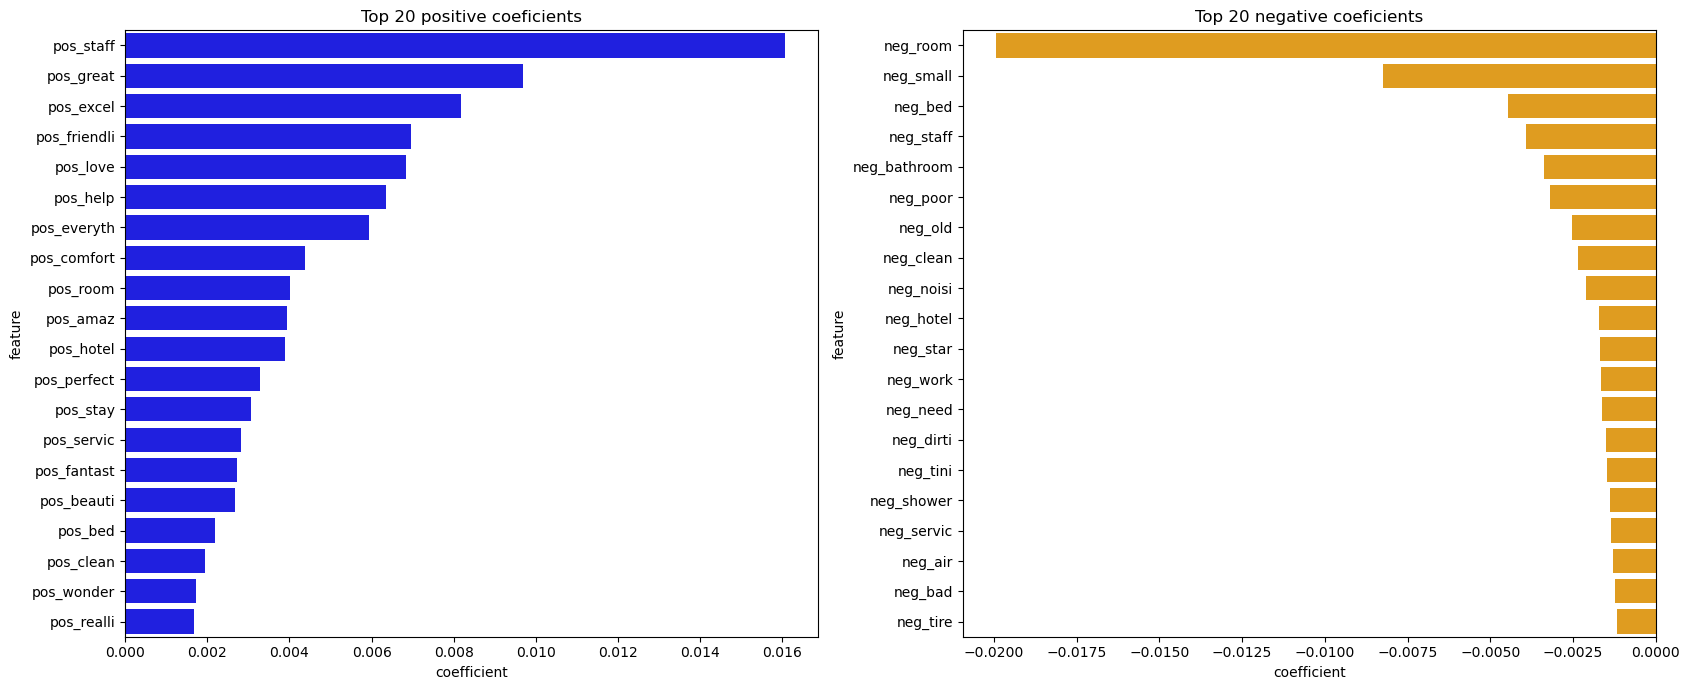

In [39]:
# create 2 subplots
fig, ax = plt.subplots(1,2, figsize=(17,7))

# plot top 20 positive coeficients
sns.barplot(x='coef', y='feature', data= top_20_pos, ax=ax[0], color = 'blue')
ax[0].set_title('Top 20 positive coeficients')
ax[0].set_xlabel('coefficient')
ax[0].set_ylabel('feature')

# plot top 20 negative coeficients
sns.barplot(x='coef', y='feature', data= top_20_neg, ax=ax[1], color = 'orange')
ax[1].set_title('Top 20 negative coeficients')
ax[1].set_xlabel('coefficient')
ax[1].set_ylabel('feature')

# show plots
plt.tight_layout()
plt.show()

**Observation:** Looking at the plots, we can see that even the most prodective worda has a low coeficient.

* In the positive reviews, we can see words that we expect such as great, friendly, love, comfort, amazing, perfect, etc.
* In the negative reviews, we also see words that we expect such as small, poor, old, noisy, dirty, bad, etc.
* There are slso some words that we see in commonsuch as staff, room, bed, clean,etc. This means that we could possibly do some further cleaning so that model is not confused when it sees these words.

# Decision Tree

The next model that we are going to perform is a Decision Tree Classifier. This model will create decision boundaries by probing further into the data.

It is important to note that Decision Trees can easily overfit if they dig too deep. This is something that we will be looking out for.

First, we will be training and testing our data on the base model (no parameters tweaked):

### Base Model

In [40]:
# Import decision tree classifier
from sklearn.tree import DecisionTreeClassifier

# instantsiate and fit decision tree classifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)

# train and test scores
print(f'Train score: {dtc.score(X_train,y_train)}')
print(f'Test score: {dtc.score(X_test,y_test)}')

Train score: 1.0
Test score: 0.698835403726708


As you can see, our model is severly over fitting with 30% gap between train and test accuracies. we can mitigate this by optimizing our hyper parameters, mainly `max_depth` which specifies how deep the tree can go.

here is over updated model summary:

| **Model**     | **PCA?**| **Parameters** | **Train Accuracy(%)** | **Test Accuracy(%)** | **Notes** |
| ------------- |:-------------:| -----:|:-------------------------:|:--------------------:|:-------:|
| Logistic Regression| No | N/A |71.1|70.9|No overfitting|
| Decision Tree | No | N/A | 100 | 69.9 | Definite overfitting |

In the next step, we are going to see if we can find the `max_depth` range where our decision tree is not overfitting by looping through a range of `max_depth`. This will be done by going over a larger range and a high step size to understand an overall pattern first.

In [41]:
# range of depth to test
depth = range(1,52,10)

# Create list for train and test accuracy\
train_accuracy = []
validation_accuracy = []

# Loop through n_components
for d in depth:
    
    # Instantiate and fitt  decision tree 
    tree = DecisionTreeClassifier(max_depth=d, random_state=42)
    tree.fit(X_train,y_train)
    
    # Evaluate the model 
    train_accuracy.append(tree.score(X_train, y_train))
    validation_accuracy.append(tree.score(X_test,y_test))
    
    # print done statement for each depth
    print(f'Done with depth {d}.')

Done with depth 1.
Done with depth 11.
Done with depth 21.
Done with depth 31.
Done with depth 41.
Done with depth 51.


Now we have all our train and test accuracies stored in lists, so we can plot them out to find our best `max_depth`:

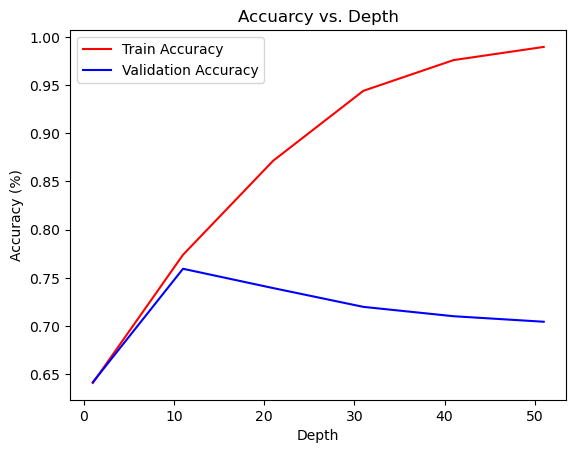

In [43]:
# Train and Validation Accuracy vs. Depth
plt.plot(depth, train_accuracy, label = 'Train Accuracy', color = 'red')
plt.plot(depth, validation_accuracy, label = 'Validation Accuracy', color = 'blue')
plt.title('Accuarcy vs. Depth')
plt.xlabel('Depth')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

**Observation:** After ploting out our train and test accuarciesover the range of `max_depth` that we tested, we can see that our model starts to over fit after 10. It looks between 4 and 10 is the best max_depth range for our model.

This is valuable info for our next step, Hyperparameter Optimization. Now that we have small range in which we should optimize, out grid search run time will be a lot faster.

### Grid search 1

We are going to performing a 5 fold Cross Validation Grid Search with our decision tree model. The grid search will allow us to test a range of specific hyper parameters will output the best combination.

In this grid search, we will be first scaling the data using Standard Scaler (tranform the numerical columns so that they now have values between -1 and 1)

Then we will be using principal component analysis to reduce the dimensions our data. PCA will craete new features that contain certain combinationsof our orginal features. We are setting a number of PCA components to 20 for this specific search.

Finally, we will be testinfg the range 3 hyper parameters:

1. Max_Depth - the maximum depth of the tree
2. Min_Samples_Split - the minimum number of samples to include in each split for an internal (non-leaf) node.
3. Min_Samples_Leaf - the minimum number of samples to be included in an external node (or leaf node).

In [45]:
# import gridsearch, standard scaler, pipeline, pca, and time
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import time

# start time
start_time = time.time()

# estimator 
estimator = Pipeline([
    ('ss',StandardScaler()),
    ('pca',PCA(n_components=20)), #PCA needs scaling but Decision Tree doesn't
    ('dtc',DecisionTreeClassifier())
    
])

# parameters
params = {
    'dtc__max_depth': [7,10], # using 7 and 10 based on out previous graph
    'dtc__min_samples_split': [2,4,6,8],
    'dtc__min_samples_leaf': [2,4,6,8]
}

# grid search
grid = GridSearchCV(estimator=estimator, param_grid=params, cv=5, verbose=2, refit=False)
grid.fit(X_train,y_train)

# end time
end_time = time.time()

#print time taken
print(f'Time taken: {end_time-start_time} seconds')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END dtc__max_depth=7, dtc__min_samples_leaf=2, dtc__min_samples_split=2; total time=  44.3s
[CV] END dtc__max_depth=7, dtc__min_samples_leaf=2, dtc__min_samples_split=2; total time=  39.8s
[CV] END dtc__max_depth=7, dtc__min_samples_leaf=2, dtc__min_samples_split=2; total time=  39.3s
[CV] END dtc__max_depth=7, dtc__min_samples_leaf=2, dtc__min_samples_split=2; total time=  35.6s
[CV] END dtc__max_depth=7, dtc__min_samples_leaf=2, dtc__min_samples_split=2; total time=  33.3s
[CV] END dtc__max_depth=7, dtc__min_samples_leaf=2, dtc__min_samples_split=4; total time=  35.9s
[CV] END dtc__max_depth=7, dtc__min_samples_leaf=2, dtc__min_samples_split=4; total time=  34.2s
[CV] END dtc__max_depth=7, dtc__min_samples_leaf=2, dtc__min_samples_split=4; total time=  34.2s
[CV] END dtc__max_depth=7, dtc__min_samples_leaf=2, dtc__min_samples_split=4; total time=  33.6s
[CV] END dtc__max_depth=7, dtc__min_samples_leaf=2, dtc__min_samp

[CV] END dtc__max_depth=10, dtc__min_samples_leaf=2, dtc__min_samples_split=2; total time=  41.7s
[CV] END dtc__max_depth=10, dtc__min_samples_leaf=2, dtc__min_samples_split=4; total time=  40.2s
[CV] END dtc__max_depth=10, dtc__min_samples_leaf=2, dtc__min_samples_split=4; total time=  40.7s
[CV] END dtc__max_depth=10, dtc__min_samples_leaf=2, dtc__min_samples_split=4; total time=  40.6s
[CV] END dtc__max_depth=10, dtc__min_samples_leaf=2, dtc__min_samples_split=4; total time=  40.2s
[CV] END dtc__max_depth=10, dtc__min_samples_leaf=2, dtc__min_samples_split=4; total time=  40.7s
[CV] END dtc__max_depth=10, dtc__min_samples_leaf=2, dtc__min_samples_split=6; total time=  41.2s
[CV] END dtc__max_depth=10, dtc__min_samples_leaf=2, dtc__min_samples_split=6; total time=  41.0s
[CV] END dtc__max_depth=10, dtc__min_samples_leaf=2, dtc__min_samples_split=6; total time=  40.5s
[CV] END dtc__max_depth=10, dtc__min_samples_leaf=2, dtc__min_samples_split=6; total time=  40.0s
[CV] END dtc__max_de

We can see our grid search look just about an hour to complete.

Now that it is done, we can extract our best parameters: 

In [46]:
# best parameters
grid.best_params_

{'dtc__max_depth': 10, 'dtc__min_samples_leaf': 8, 'dtc__min_samples_split': 2}

Looking at the best parameters we see a `max_depth` of 10, `min_samples_leaf` of 8 and `min_samples_split` of 8.

Given that these are all of max values that we tested, the next step would be to perform another grid search that looks atlarger values for `min_samples_leaf` of 8, and `min_samples_split`. We do not want to increase `max_depth` any further given that the model starts to overfitting that point.

We can now take our best parameters and fit them to a new Dicision Tree model and see if the model is no longer over fitting:

In [47]:
# intantiate and fit decision tree classifier with the best parameters
dtc = DecisionTreeClassifier(max_depth=10, min_samples_leaf=8, min_samples_split=8)
dtc.fit(X_train,y_train)

# train and test scores
print(f'Train Score: {dtc.score(X_train,y_train)}')
print(f'Test Score: {dtc.score(X_test,y_test)}')

Train Score: 0.7667747587338477
Test Score: 0.7578881987577639


Our train accuracy has significantlly decreased from 100% to 76.7% and our test accuracy has increased from 69.9% to 75.8%. The most important change is that our model is no longer over fitting in the slightest.

Let's take a look at our classification report and confusion matrix.

In the classification report, we are mainly looking at two scores: precision and recall
* precision: The percentage of positive predictions that are actually positive
* recall: The percentage of actual positives that our model predicted positive

              precision    recall  f1-score   support

           0       0.74      0.68      0.71     55371
           1       0.77      0.82      0.79     73429

    accuracy                           0.76    128800
   macro avg       0.75      0.75      0.75    128800
weighted avg       0.76      0.76      0.76    128800



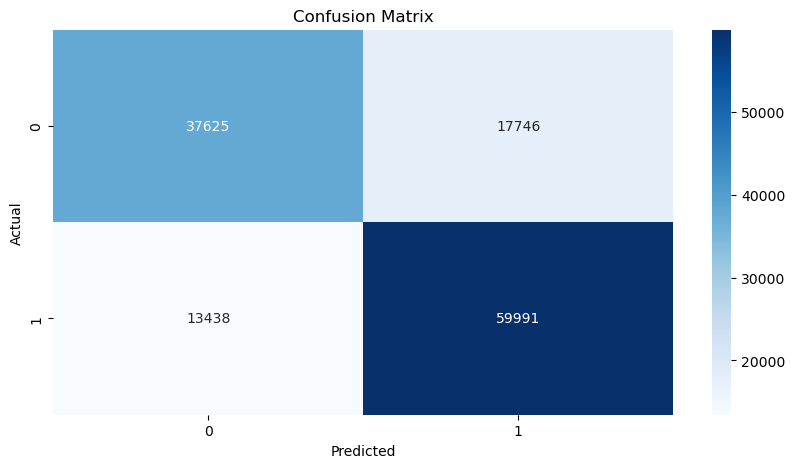

In [49]:
# import classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

# Classification report 
print(classification_report(y_test, dtc.predict(X_test)))

# confusion matrix heatmap
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, dtc.predict(X_test)), annot = True, cmap = 'Blues', fmt = 'g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Looking at the classification report, we can see that our model was able to correctly identify 82% of the good reviews but had a quite a few false positives given the precision score of 77%.

For the bad reviews, our model was only able to catch 68%. This could be due to imbalance of target column. In the future, we might want to downsample good reviews to a more 50/50 split.

Here is our updated model summary:

| **Model**     | **PCA?**| **Parameters** | **Train Accuracy(%)** | **Test Accuracy(%)** | **Notes** |
| ------------- |:-------------:| -----:|:-------------------------:|:--------------------:|:-------:|
| Logistic Regression| No | N/A |71.1|70.9|No overfitting|
| Decision Tree | No | N/A | 100 | 69.9 | Definite overfitting |
| Dicision Tree Grid | 20 Componenets | max_depth=10,min_samples_split=8,min_samples_leaf=8 | 76.6 | 75.7 | No longer over fitting, best parameters max of range, low recall class 0 | 

### Grid Search 2

Next, we are going to run another grid search, keeping `max_depth` at 10, and increasing the other two parameters to see if can improve our accuracies, precision and recall:

In [50]:
# start time
start_time = time.time()

# estimator 
estimator2 = Pipeline([
    ('ss',StandardScaler()),
    ('pca',PCA(n_components=20)), #PCA needs scaling but Decision Tree doesn't
    ('dtc',DecisionTreeClassifier(max_depth=10))
    
])

# parameters
params2 = {
    'dtc__min_samples_split': [8,10,12,14],
    'dtc__min_samples_leaf': [8,10,12,14]
}

# grid search
grid2 = GridSearchCV(estimator=estimator2, param_grid=params2, cv=5, verbose=2, refit=False)
grid2.fit(X_train,y_train)

# end time
end_time = time.time()

#print time taken
print(f'Time taken: {end_time-start_time} seconds')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..dtc__min_samples_leaf=8, dtc__min_samples_split=8; total time=  46.6s
[CV] END ..dtc__min_samples_leaf=8, dtc__min_samples_split=8; total time=  43.0s
[CV] END ..dtc__min_samples_leaf=8, dtc__min_samples_split=8; total time=  42.4s
[CV] END ..dtc__min_samples_leaf=8, dtc__min_samples_split=8; total time=  41.7s
[CV] END ..dtc__min_samples_leaf=8, dtc__min_samples_split=8; total time=  41.7s
[CV] END .dtc__min_samples_leaf=8, dtc__min_samples_split=10; total time=  44.3s
[CV] END .dtc__min_samples_leaf=8, dtc__min_samples_split=10; total time=  43.0s
[CV] END .dtc__min_samples_leaf=8, dtc__min_samples_split=10; total time=  41.2s
[CV] END .dtc__min_samples_leaf=8, dtc__min_samples_split=10; total time=  42.1s
[CV] END .dtc__min_samples_leaf=8, dtc__min_samples_split=10; total time=  40.9s
[CV] END .dtc__min_samples_leaf=8, dtc__min_samples_split=12; total time=  40.8s
[CV] END .dtc__min_samples_leaf=8, dtc__min_samp

This second grid search took just about 30 min to complete.

Now that it is done, we can get our best parameters just like before.

In [51]:
grid2.best_params_

{'dtc__min_samples_leaf': 12, 'dtc__min_samples_split': 10}

Instead of 8, both parameters are now showing 14 as their best value.

Again, these are also the max out of range that we tested. This makes sense as we have a large amount of data and only setting max depth to 10,meaning that after 10 splits, none of our nodes will have a small number of values. We will not be going any further for the sake of time.

Let's fit our best parameters to Dicison Tree and see if our scores have increased:

In [52]:
# intantiate and fit decision tree classifier with the best parameters
dtc = DecisionTreeClassifier(max_depth=10, min_samples_leaf=14, min_samples_split=14)
dtc.fit(X_train,y_train)

# train and test scores
print(f'Train Score: {dtc.score(X_train,y_train)}')
print(f'Test Score: {dtc.score(X_test,y_test)}')

Train Score: 0.7662882150316124
Test Score: 0.7581909937888198


We can see here that our test accuracy only increased by 0.1%.

The model is not over fitting.

Let's take a look at our classification report and confusion matrix:

              precision    recall  f1-score   support

           0       0.74      0.68      0.71     55371
           1       0.77      0.82      0.79     73429

    accuracy                           0.76    128800
   macro avg       0.75      0.75      0.75    128800
weighted avg       0.76      0.76      0.76    128800



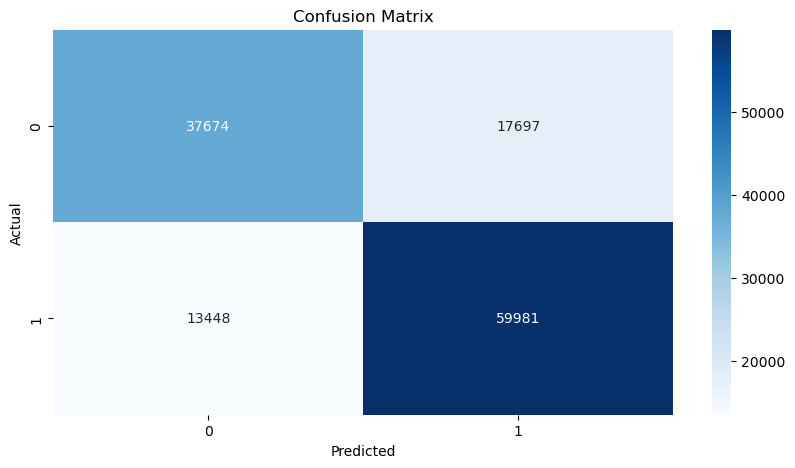

In [53]:
# Classification report 
print(classification_report(y_test, dtc.predict(X_test)))

# confusion matrix heatmap
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, dtc.predict(X_test)), annot = True, cmap = 'Blues', fmt = 'g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Since our accuracy increased marginally, we will count this as our best model.

Next step would be to test a wider range of parameters to see if this can be improved.

Here is our final model summary:

| **Model**     | **PCA?**| **Parameters** | **Train Accuracy(%)** | **Test Accuracy(%)** | **Notes** |
| ------------- |:-------------:| -----:|:-------------------------:|:--------------------:|:-------:|
| Logistic Regression| No | N/A |71.1|70.9|No overfitting|
| Decision Tree | No | N/A | 100 | 69.9 | Definite overfitting |
| Dicision Tree Grid | 20 Componenets | max_depth=10,min_samples_split=8,min_samples_leaf=8 | 76.6 | 75.7 | No longer over fitting, best parameters max of range, low recall class 0 | 
| Dicision Tree Grid2 | 20 Componenets | max_depth=10,min_samples_split=14,min_samples_leaf=14 | 76.6 | 75.8 | Minimal increase, best params max of range, same matrix |

We can see that our optimized Decision Tree model did not perform a whole lot better than our base logistic regression model. Although we would still like to test a larger range of parameters on our tree model. I am assuming that this will minimally increase accuracy.

Given that our base logistic regression had a similar accuarcy as our base decision tree model without overfitting, our next step could be to focus on our logistic regression more by using various scalling methods, PCA, and optimizing our hyper parameters through a grid search.

# Conclusion

The entire workflow for this project involved preprocessing the data, conducting some EDA and creating models to identify the review score based on reviews given by customers as well as factors about the hotels and reviews. The EDA showed first:
* 75% of reviewers have less than 8 total reviews given
* 75% of review words counts are under 23
* Most reviewers stay at the hotel for less than 3 days
* Our data spans over 3 years, from 2015 to 2017

The model showcased the best model is a Decision Tree with 20 components in `PCA`, `max_depth` of 10, `min_samples_split` of 14 and `min_samples_leaf` of 14. While the pca might make interpretability more difficult, it gives test score of 75.8% (almost 4% higher than Logistic Regression and base Decision Tree models). Further modelling and optimization can be tested by using a pipeline including Grid Search CV or Randomized Search CV. The latter can decrease the amount of processing time but generally get agood resulting optimization in model.